<a href="https://colab.research.google.com/github/zi-onion/ESAA/blob/main/04_12_LightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 07 LightGBM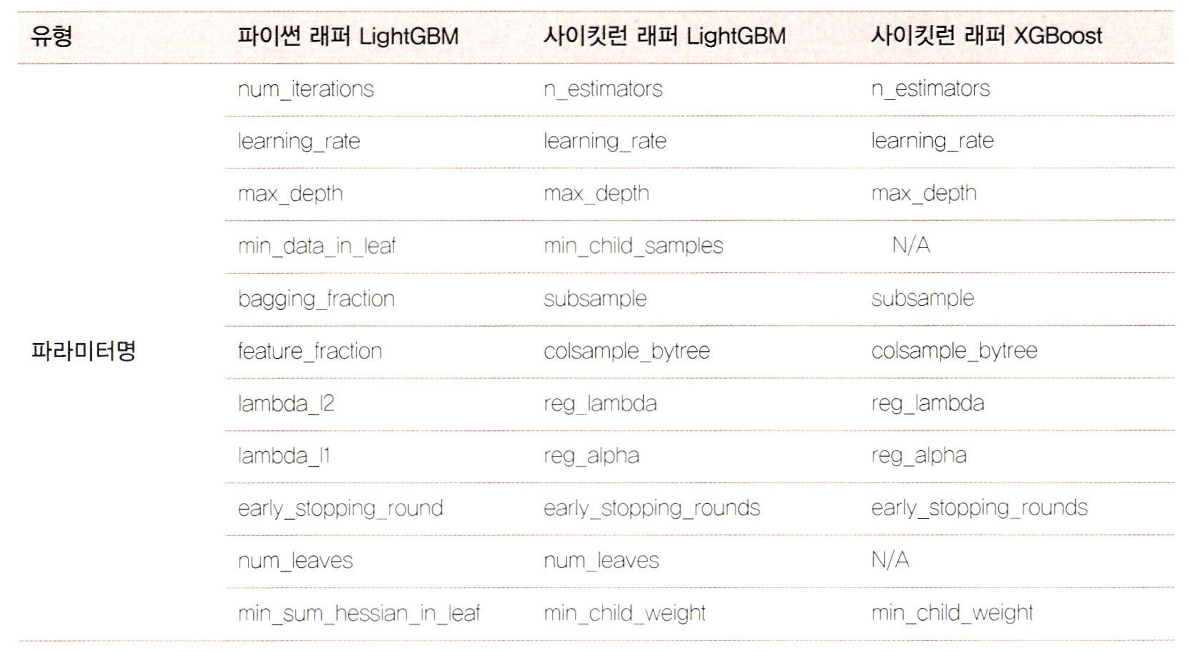

LightGBM의 가장 큰 장점은 XGBoost보다 학습에 걸리는 시간이 훨씬 적고, 메모리 사용량도 상대적으로 적다는 점이다.
LightGBM의 한가지 단점은 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉽다는 것이다.

리프 중심 트리 분할(Leaf Wise)방식을 사용

-> 보통은 최대한 균형 잡힌 트리를 유지하면서 분할하기 때문에 트리의 깊이가 최소화 될 수 있음.

-> 그러나 LightGBM의 경우 균형을 맞추지 않고 분할, 최대 손실값을 갖는 리프노드를 지속적으로 분할해 결국은 균형 트리 분할 방식보다 예측 오류 손실을 최소화시킴.

lightgbm 패키지 내에 사이킷런 래퍼 LightGBM 클래스는 분류를 위한 LGBMClassifier 클래스와 회귀를 위한 LGBMRegressor클래스 모두 가짐.

### LightGBM 하이퍼파라미터

#### 주요 파라미터

- num_iterations[defaultt=100]
- learning_rate[defaultt=0.1]
- max_depth[defaultt=-1]
- max_data_in_leaf[defaultt=20]
- num_leaves[defaultt=31]
- boosting[default=gbdt]
- bagging_fraction[defaultt=1.0]
- lambda_l2[defaultt=0.0]
- lambda_l1[defaultt=0.0]

#### Learning Task 파라미터
- objective

### 하이퍼 파라미터 튜닝 방안

- num_leaves는 개별 트리가 가질 수 있는 최대 리프의 개수로, LighiGBM모델의 복잡도를 제어하는 주요 파라미터.
일반적으로nu num_leaves의 개수를 높이면 정확도가 높아지지만, 반대로 트리의 깊이가 깊어지고 모델이 복잡도가 커져 과적합 영향도가 커집니다.

- min_data_in_leaf는 사이킷런 래퍼 클래스에서는 min_chid_samples로 이름이 바뀜. 과적합을 개선하기 위한 중요한 파라미터. num_leaves와 학습 데이터의 크기에 따라 달라지지만, 보통 큰 값으로 설정하면 트리가 깊어지는 것을 방지함.

- max_depith는 명시적으로 깊이의 크기를 제한.nu m_leaves,min_data_in_leaf와 결합해 과적합을 개선하는데 사용.

learning_rate를 작게 하면서 n_estimators를 크게 하는 것은 부스팅 계열 튜닝에서 가장 기본적인 튜닝방안

### 파이썬 래퍼Light GBM과 사이킷런 래퍼XGBoost, LightGBM 하이퍼파라미터 비교



### LightGBM적용- 위스콘신 유방암 예측

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
# LightGBM의 파이썬 패키지인 lightgbm에서 LGBMClassifier 임포트
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(ftr, target, test_size = 0.2, random_state=156)

# 앞서 XGBoost와 동일하게 n_estimators는 400설정.
lgbm_wrapper=LGBMClassifier(n_estimators=400)

# LightGBM도 XGBoost와 동일하게 조기 중단 수행 가능.
evals = [(X_test, y_test)]
lgbm_wrapper.fit(X_train, y_train, eval_metric="logloss", eval_set = evals)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[LightGBM] [Info] Number of positive: 280, number of negative: 175
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4542
[LightGBM] [Info] Number of data points in the train set: 455, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.615385 -> initscore=0.470004
[LightGBM] [Info] Start training from score 0.470004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
def get_clf_eval(y_test, pred=None, pred_proba=None) :
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # roc_auc 추가
    print('정확도 : {0:.4f}, 정밀도 : {1:.4f}, 재현율 : {2:.4f}, \
    F1 : {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [11]:
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[32  5]
 [ 2 75]]
정확도 : 0.9386, 정밀도 : 0.9375, 재현율 : 0.9740,     F1 : 0.9554, AUC:0.9926


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

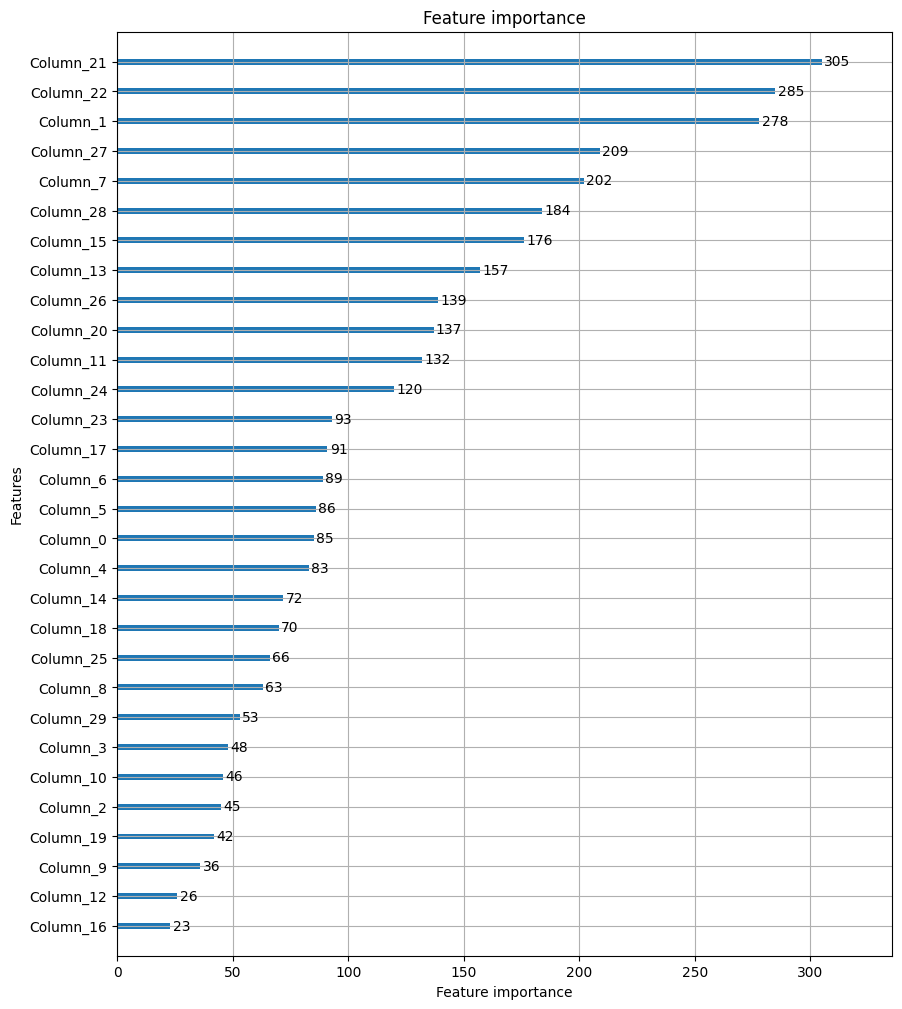

In [12]:
# plot_importance()를 이용해 피처 중요도 시각화
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)

## 08 분류실습 - 캐글 산탄데르 고객 만족 예측

### 데이터 전처리

In [14]:
import numpy as pn
import pandas as pd
import matplotlib.pyplot as pit
import matplotlib

cust_df = pd.read_csv("/content/train.csv", encoding='latin-1')
print ('dataset shape:', cust_df.shape)
cust_df.head (3)

dataset shape: (76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.17,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.03,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.77,0


In [15]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [16]:
print(cust_df['TARGET'].value_counts())
unsatisfied_cnt=cust_df[cust_df['TARGET']==1].TARGET.count()
total_cnt = cust_df.TARGET.count()
print('unsatisfied 비율은 {0:.2f}'.format((unsatisfied_cnt/total_cnt)))

TARGET
0    73012
1     3008
Name: count, dtype: int64
unsatisfied 비율은 0.04


In [17]:
cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,...,7.935824,1.365146,12.215580,8.784074,31.505324,1.858575,76.026165,56.614351,1.172358e+05,0.039569
std,43781.947379,39033.462364,12.956486,1614.757313,339.315831,546.266294,93.155749,153.737066,30.604864,36.513513,...,455.887218,113.959637,783.207399,538.439211,2013.125393,147.786584,4040.337842,2852.579397,1.826646e+05,0.194945
min,1.000000,-999999.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.163750e+03,0.000000
25%,38104.750000,2.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.787061e+04,0.000000
50%,76043.000000,2.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.064092e+05,0.000000
75%,113748.750000,2.000000,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187563e+05,0.000000
max,151838.000000,238.000000,105.000000,210000.000000,12888.030000,21024.810000,8237.820000,11073.570000,6600.000000,6600.000000,...,50003.880000,20385.720000,138831.630000,91778.730000,438329.220000,24650.010000,681462.900000,397884.300000,2.203474e+07,1.000000


In [18]:
cust_df['var3'].replace(-999999, 2, inplace=True)
cust_df.drop('ID', axis=1, inplace=True)

# 피처 세트와 레이블 세트 분리, 레이블 칼럼은 DataFrame의 맨 마지막에 위치해 칼럼 위치 -1로 분리
X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]
print('피처 데이터 shape: {0}'.format(X_features.shape))

피처 데이터 shape: (76020, 369)


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size = 0.2, random_state=0)
train_cnt = y_train.count()
test_cnt = y_test.count()
print('학습 세트 Shape: {0}, 테스트 세트 Shape: {1}'.format(X_train.shape, X_test.shape))

print('학습 세틑 레이블 값 분포 비율')
print(y_train.value_counts()/train_cnt)
print('\n 테스트 세트 레이블 값 분포 비율')
print(y_test.value_counts()/test_cnt)

학습 세트 Shape: (60816, 369), 테스트 세트 Shape: (15204, 369)
학습 세틑 레이블 값 분포 비율
TARGET
0    0.960964
1    0.039036
Name: count, dtype: float64

 테스트 세트 레이블 값 분포 비율
TARGET
0    0.9583
1    0.0417
Name: count, dtype: float64


#### XGBoost 모델 학습과 하이퍼 파라미터 튜닝

XGBoost의 학습모델 : 사이킷런 래퍼 XGBClassifier 기반으로 학습 수행

In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# n_estimators는 500으로, random state는 예제 수행 시마다 동일 예측 결과를 위해 설정.
xgb_clf = XGBClassifier(n_estimators=500, random_state=156)

# 성능 평가 지표를 auc로, 조기 중단 파라미터는 100으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 100,
            eval_metric="auc", eval_set=[(X_train, y_train), (X_test, y_test)])

xgb_roc_score = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.83789	validation_1-auc:0.82554
[1]	validation_0-auc:0.84273	validation_1-auc:0.82878
[2]	validation_0-auc:0.84901	validation_1-auc:0.83359
[3]	validation_0-auc:0.85530	validation_1-auc:0.83767
[4]	validation_0-auc:0.85891	validation_1-auc:0.83909
[5]	validation_0-auc:0.86117	validation_1-auc:0.84156
[6]	validation_0-auc:0.86378	validation_1-auc:0.84138
[7]	validation_0-auc:0.86737	validation_1-auc:0.84048
[8]	validation_0-auc:0.87021	validation_1-auc:0.84162
[9]	validation_0-auc:0.87258	validation_1-auc:0.84100
[10]	validation_0-auc:0.87505	validation_1-auc:0.84117
[11]	validation_0-auc:0.87747	validation_1-auc:0.84111
[12]	validation_0-auc:0.87872	validation_1-auc:0.84114
[13]	validation_0-auc:0.88087	validation_1-auc:0.84066
[14]	validation_0-auc:0.88208	validation_1-auc:0.84014
[15]	validation_0-auc:0.88340	validation_1-auc:0.83965
[16]	validation_0-auc:0.88557	validation_1-auc:0.83950
[17]	validation_0-auc:0.88664	validation_1-auc:0.84013
[18]	validation_0-au

In [21]:
# XGBoost의 하이퍼 파라미터 튜닝
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트이 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
xgb_clf = XGBClassifier(n_estimators=100)

params={ 'max_depth':[5,7], 'min_child_weight':[1,3],'colsample_bytree':[0.5,0.75] }
# cv는 3으로 지정
gridcv = GridSearchCV(xgb_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, early_stopping_rounds=30, eval_metric='auc',
           eval_set=[(X_train,y_train),(X_test,y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)

xgb_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))

[0]	validation_0-auc:0.80705	validation_1-auc:0.80366
[1]	validation_0-auc:0.80607	validation_1-auc:0.80683
[2]	validation_0-auc:0.79962	validation_1-auc:0.80156
[3]	validation_0-auc:0.80463	validation_1-auc:0.80839
[4]	validation_0-auc:0.82994	validation_1-auc:0.82595
[5]	validation_0-auc:0.84026	validation_1-auc:0.83143
[6]	validation_0-auc:0.84642	validation_1-auc:0.83616
[7]	validation_0-auc:0.84635	validation_1-auc:0.83399
[8]	validation_0-auc:0.85018	validation_1-auc:0.83592
[9]	validation_0-auc:0.85084	validation_1-auc:0.83463
[10]	validation_0-auc:0.85227	validation_1-auc:0.83362
[11]	validation_0-auc:0.85527	validation_1-auc:0.83695
[12]	validation_0-auc:0.85693	validation_1-auc:0.83944
[13]	validation_0-auc:0.85857	validation_1-auc:0.83941
[14]	validation_0-auc:0.85898	validation_1-auc:0.83988
[15]	validation_0-auc:0.85928	validation_1-auc:0.83954
[16]	validation_0-auc:0.86102	validation_1-auc:0.83887
[17]	validation_0-auc:0.86239	validation_1-auc:0.83818
[18]	validation_0-au

In [25]:
# n_estimators는 1000으로 증가시키고, lerning_rate=0.2로 감소, reg_alpha=0.03으로 추가함.
xgb_clf = XGBClassifier(n_estimators=1000, random_state=156, learning_rate=0.2, max_depth=7,
                        min_child_weight=1, colsample_bytree=0.75, reg_alpha=0.03)

# 성능 평가 지표를 auc로, 조기 중단 파라미터 값은 200으로 설정하고 학습 수행.
xgb_clf.fit(X_train, y_train, early_stopping_rounds = 200,
            eval_metric='auc', eval_set = [(X_train, y_train),(X_test,y_test)])

xgb_roc_score=roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(xgb_roc_score))


[0]	validation_0-auc:0.84570	validation_1-auc:0.82819
[1]	validation_0-auc:0.84210	validation_1-auc:0.82045
[2]	validation_0-auc:0.85416	validation_1-auc:0.83037
[3]	validation_0-auc:0.86019	validation_1-auc:0.83659
[4]	validation_0-auc:0.86345	validation_1-auc:0.83901
[5]	validation_0-auc:0.86687	validation_1-auc:0.83931
[6]	validation_0-auc:0.86724	validation_1-auc:0.83989
[7]	validation_0-auc:0.87149	validation_1-auc:0.84066
[8]	validation_0-auc:0.87347	validation_1-auc:0.84047
[9]	validation_0-auc:0.87322	validation_1-auc:0.83992
[10]	validation_0-auc:0.87849	validation_1-auc:0.84136
[11]	validation_0-auc:0.88193	validation_1-auc:0.84225
[12]	validation_0-auc:0.88311	validation_1-auc:0.84209
[13]	validation_0-auc:0.88539	validation_1-auc:0.84391
[14]	validation_0-auc:0.88755	validation_1-auc:0.84494
[15]	validation_0-auc:0.88958	validation_1-auc:0.84535
[16]	validation_0-auc:0.89109	validation_1-auc:0.84575
[17]	validation_0-auc:0.89278	validation_1-auc:0.84594
[18]	validation_0-au

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

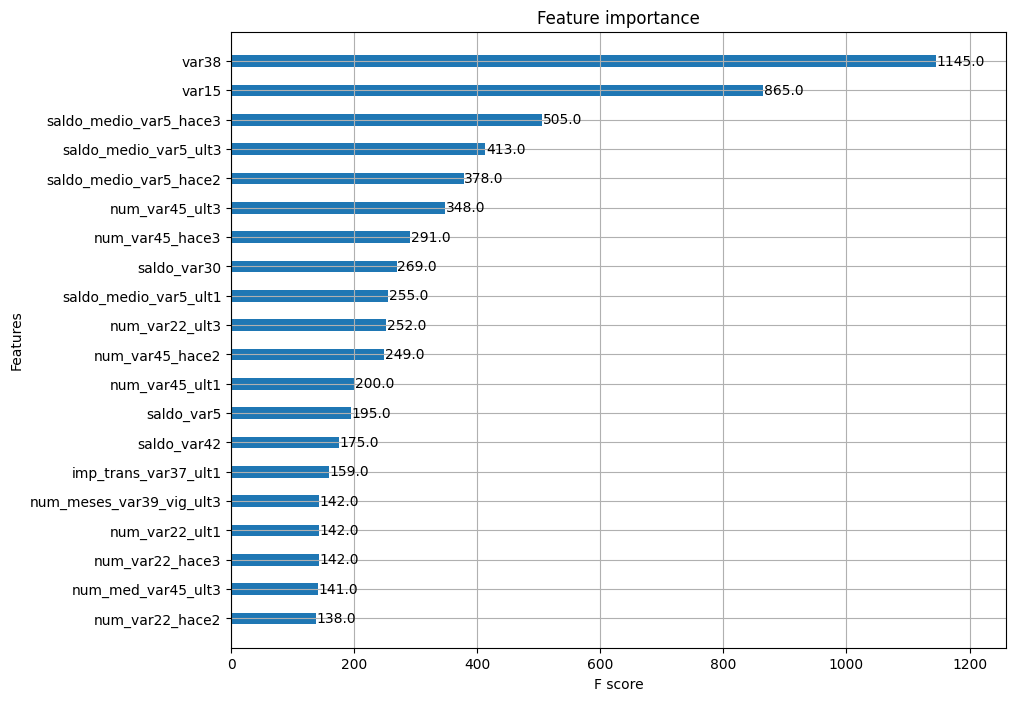

In [26]:
# 튜닝된 모델에서 각 피처의 중요도를 피처 중요도 그래프로 나타내기 : xgboost모듈의 plot_importance()메서드
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1,figsize = (10,8))
plot_importance(xgb_clf, ax=ax, max_num_features=20, height=0.4)

#### LightGBM 모델 학습과 하이퍼 파라미터 튜닝

In [29]:
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

lgbm_clf=LGBMClassifier(n_estimators=500)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, eval_metric='auc', eval_set=evals)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:,1], average='macro')
print('ROC_AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 2374, number of negative: 58442
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.321688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14308
[LightGBM] [Info] Number of data points in the train set: 60816, number of used features: 251
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039036 -> initscore=-3.203459
[LightGBM] [Info] Start training from score -3.203459
ROC_AUC: 0.8140


In [31]:
from sklearn.model_selection import GridSearchCV

# 하이퍼 파라미터 테스트의 수행 속도를 향상시키기 위해 n_estimators를 100으로 감소
lgbm_clf=LGBMClassifier(n_estimators=100)

params = {'num_leaves':[32,64],
          'max_depth':[128,160],
          'min_child_samples':[60,100],
         'subsample':[0.8,1]}

# cv는 3으로 지정
gridcv=GridSearchCV(lgbm_clf, param_grid=params, cv=3)
gridcv.fit(X_train, y_train, eval_metric='auc',
           eval_set=[(X_train, y_train),(X_test, y_test)])

print('GridSearchCV 최적 파라미터:', gridcv.best_params_)
lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:,1], average='macro')
print('ROC AUC: {0:.4f}'.format(lgbm_roc_score))

[LightGBM] [Info] Number of positive: 1583, number of negative: 38961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.159251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12926
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 203
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.039044 -> initscore=-3.203239
[LightGBM] [Info] Start training from score -3.203239
[LightGBM] [Info] Number of positive: 1583, number of negative: 38961
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.065561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13095
[LightGBM] [Info] Number of data points in the train set: 40544, number of used features: 205
[LightGBM] [Info